In [3]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utitility Function</h3>
</center>

In [6]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

# visualization
def show_result2group(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neg',
                   'False Pos', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(2,2)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def show_result5group(ypred: np.array, ytarget: np.array) -> None:
    label = [1,2,3,4,5][::-1]
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'True Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'True Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'True Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(5, 5)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>NN Utility Function</h3>
</center>

In [43]:
import gensim
import multiprocessing
from tensorflow.keras import models, layers, preprocessing as kprocessing


def skipGram(training_corpus: list) -> None:
    """
    This model will be use to embedded the words

    training_corpus: list of list of words, i.e list of split sentences
    """
    
    w2v_model = gensim.models.word2vec.Word2Vec(
        training_corpus, 
        epochs=50, 
        vector_size=300, 
        sample=6e-5,
        alpha=0.001, 
        min_alpha=0.0007, 
        window=15, 
        min_count=5,
        workers=multiprocessing.cpu_count()-1)
    w2v_model.init_sims(replace=True)

    return w2v_model

def textTokenizer(training_corpus: list) -> None:
    """
    This model will be use to tokenized the text and get the id

    training_corpus: list of list of words, i.e list of split sentences
    """

    tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN")
    tokenizer.fit_on_texts(training_corpus)

    return tokenizer

def textToIDs(tokenizer: kprocessing.text.Tokenizer, training_corpus: list) -> None:
    """
    This function will be use to convert texts to id & added padding

    tokenizer: needs to be kprocessing.text.Tokenizer object
    training_corpus: list of list of words, i.e list of split sentences
    """

    text2seq= tokenizer.texts_to_sequences(training_corpus)
    data = kprocessing.sequence.pad_sequences(
        text2seq, 
        maxlen=75, 
        padding="post", 
        truncating="post")

    return data

def getEmbeddedData(w2v_model: gensim.models.word2vec.Word2Vec, tokenizer: kprocessing.text.Tokenizer) -> None:
    """
    This function will generate the embedded matrix to map the word id
    
    w2v_model: will be use to get the vector
    tokenizer: will be use to get the corpus mapping dictionary
    """
    
    embeddings = np.zeros((len(tokenizer.word_index)+1, w2v_model.wv.vector_size))
    for word, index in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embeddings[index] = w2v_model.wv[word]
    
    return embeddings

<center>
    <h3>Pre-Process</h3>
</center>

Goals
- Explore embedding from raw text instead of processed text with NN
- Processed text without embedding with NN

In [8]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [9]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [10]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

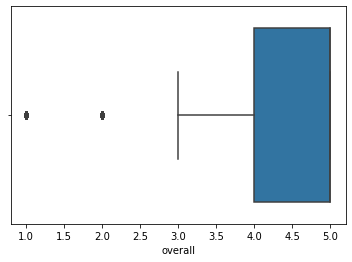

In [11]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

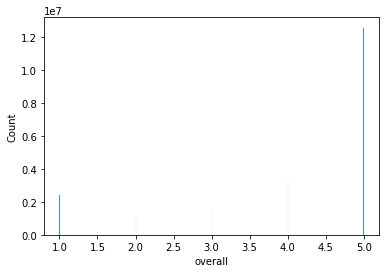

In [12]:
sns.histplot(df['overall'])

In [13]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [14]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [15]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [16]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [17]:
# filter to only get 1 & 5 output
dfdata = dfdata[dfdata['overall'].apply(lambda x: x in (1, 5))]

In [18]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [19]:
dfdataMain.shape

(500000, 2)

In [20]:
# for training & testing
target_n = 480 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [21]:
# for validation
target_n = 48 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [22]:
# for validation training & testing
target_n = 45 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

<AxesSubplot:xlabel='overall', ylabel='Count'>

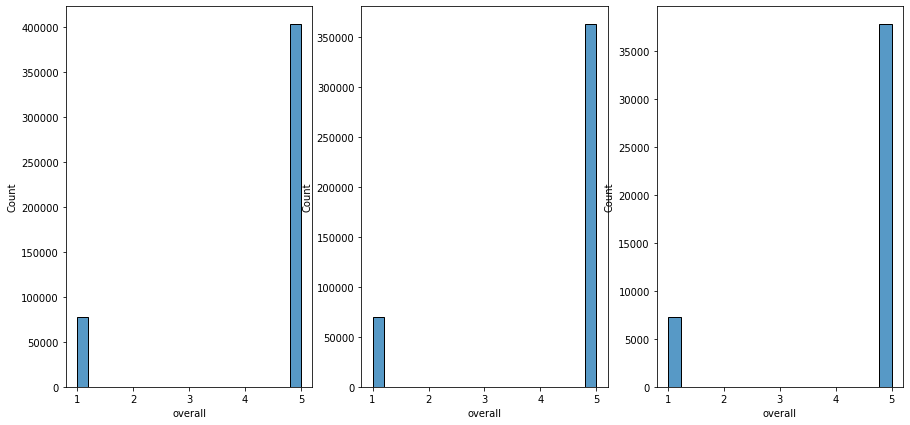

In [23]:
fig, axes = plt.subplots(figsize=(15,7), nrows=1, ncols=3)
sns.histplot(dfdataTrain['overall'], ax=axes[0])
sns.histplot(dfdataTrainSub['overall'], ax=axes[1])
sns.histplot(dfdataValidTrain['overall'], ax=axes[2])

In [24]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

465613128

In [25]:
# validation for processing

In [26]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

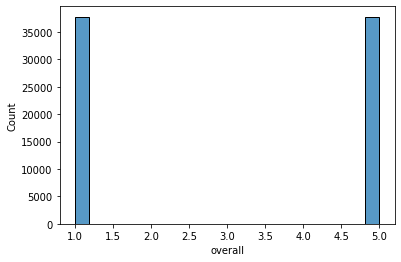

In [27]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [28]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

<center>
    <h3>NN Layer</h3>
</center>

<div style="white-space:pre-line"> Architecture with Embedding
Original Input: (75, 300) -> Flattened(75 * 300)
Layer1: {Input: (1, 22500) -> Output: (22500, 100)} = 100 Neurons
Layer2: {Input: (1, 100) -> Output: (100, 25)} = 25 Neurons
Output: {Input: (25, 2) -> Output: (2, )} = 2 Neurons
</div>

In [46]:
import torch
from torchinfo import summary
import torchtext
import torchvision
from torch.utils.data import Dataset, DataLoader


class NeuralNetworkEmbedding(torch.nn.Module):
    def __init__(self, embeddings, dropout_rate):
        super(NeuralNetworkEmbedding, self).__init__()
        
        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(embeddings)).float()
        # flatten layer
        self.flatten = torch.nn.Flatten(1)
        # fully-connected layer 1
        self.nn1 = torch.nn.Linear(22500, 100)
        # full-connected layer 2
        self.nn2 = torch.nn.Linear(100, 25)
        # output layer
        self.nn3 = torch.nn.Linear(25, 2)
        
        # dropout rate
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.nn1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn3(x)
        x = torch.nn.functional.sigmoid(x)
        return x

<div style="white-space:pre-line"> Architecture without Embedding
Original Input: (150000, ) 
Layer1: {Input: (1, 150000) -> Output: (150000, 100)} = 100 Neurons
Layer2: {Input: (1, 100) -> Output: (100, 25)} = 25 Neurons
Output: {Input: (25, 2) -> Output: (2, )} = 2 Neurons
</div>

In [145]:
import torch
from torchinfo import summary
import torchtext
import torchvision
from torch.utils.data import Dataset, DataLoader


class NeuralNetworkUnibi(torch.nn.Module):
    def __init__(self, dropout_rate):
        super(NeuralNetworkUnibi, self).__init__()
        
        # flatten layer
        self.flatten = torch.nn.Flatten(1)
        # fully-connected layer 1
        self.nn1 = torch.nn.Linear(150000, 100)
        # full-connected layer 2
        self.nn2 = torch.nn.Linear(100, 25)
        # output layer
        self.nn3 = torch.nn.Linear(25, 2)
        
        # dropout rate
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.nn1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = self.nn3(x)
        x = torch.nn.functional.sigmoid(x)
        return x

<center>
    <h3>Process</h3>
</center>

In [132]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_removeStopWords(txt)
    txt = pipe_lemmatization(txt)
    txt = re.sub('[^A-Za-z ]+', '', txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
tdf1['overall'] = tdf1['overall'].apply(lambda x: 1 if x > 1 else 0)
tdf2['overall'] = tdf2['overall'].apply(lambda x: 1 if x > 1 else 0)
tdf1['lenW'] = tdf1['reviewText'].apply(lambda x: len(x))
tdf2['lenW'] = tdf2['reviewText'].apply(lambda x: len(x))

In [134]:
training_corpus = [x.split() for x in tdf1['reviewText'].tolist()]

skipgram_model = skipGram(training_corpus)
texttokenizer_model = textTokenizer(training_corpus)
embeddedingMatrix = getEmbeddedData(skipgram_model, texttokenizer_model)

embeddedtrainX, embeddedtrainY = textToIDs(texttokenizer_model, training_corpus), tdf1['overall'].to_numpy()
embeddedtestX, embeddedtestY = textToIDs(texttokenizer_model, [x.split() for x in tdf2['reviewText'].tolist()]), tdf2['overall'].to_numpy()

In [135]:
unibitrainX, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
unibitrainY = tdf1['overall'].to_numpy()
unibitestX, unibitestY = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()

In [136]:
# create torch dataset object

class CustomTextDataset(Dataset):
    def __init__(self, x, y, transform_x, transform_y):
        self.x = x
        self.y = y
        self.transform_x = transform_x 
        self.transform_y = transform_y
        self.n = x.shape[0]

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.transform_x(self.x[idx]), self.transform_y(self.y[idx])

In [137]:
modelEmbedding = NeuralNetworkEmbedding(embeddedingMatrix, 0.9)
summary(modelEmbedding)

Layer (type:depth-idx)                   Param #
NeuralNetworkEmbedding                   --
├─Embedding: 1-1                         (9,444,000)
├─Flatten: 1-2                           --
├─Linear: 1-3                            2,250,100
├─Linear: 1-4                            2,525
├─Linear: 1-5                            52
├─Dropout: 1-6                           --
Total params: 11,696,677
Trainable params: 2,252,677
Non-trainable params: 9,444,000

In [146]:
# test sample NeuralNetworkEmbedding
model = NeuralNetworkEmbedding(embeddedingMatrix, 0.8)
datasample = torch.from_numpy(embeddedtrainX[0]).type(torch.LongTensor).reshape(1, -1)
model(datasample)

tensor([[0.4958, 0.5042]], grad_fn=<SigmoidBackward0>)

In [147]:
modelUnibi = NeuralNetworkUnibi(0.9)
summary(modelUnibi)

Layer (type:depth-idx)                   Param #
NeuralNetworkUnibi                       --
├─Flatten: 1-1                           --
├─Linear: 1-2                            15,000,100
├─Linear: 1-3                            2,525
├─Linear: 1-4                            52
├─Dropout: 1-5                           --
Total params: 15,002,677
Trainable params: 15,002,677
Non-trainable params: 0

In [148]:
# test sample NeuralNetworkUnibi
model = NeuralNetworkUnibi(0.8)
datasample = torch.from_numpy(unibitrainX[0].todense()).type(torch.float).reshape(1, -1)
model(datasample)

tensor([[0.5352, 0.5225]], grad_fn=<SigmoidBackward0>)

In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [150]:
transform_x_embedding = torch.from_numpy
transform_y_embedding = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: torch.tensor(x)),
    torchvision.transforms.Lambda(lambda x: torch.nn.functional.one_hot(x, num_classes=2).type(torch.float)),
])

In [151]:
%%time
# run model

# constant
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCHS = 50
MOMENTUM = 0.9
DROPOUT = 0.9

# model
embeddingmodel = NeuralNetworkEmbedding(embeddedingMatrix, DROPOUT).to(device)

# dataset
trainset = CustomTextDataset(embeddedtrainX, embeddedtrainY, transform_x_embedding, transform_y_embedding)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valset = CustomTextDataset(embeddedtestX, embeddedtestY, transform_x_embedding, transform_y_embedding)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

# loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


accuracy_list = []
loss_list = []
for epoch in range(EPOCHS):
    epoch_list = []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_hat = embeddingmodel(x)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

        epoch_list.append(loss.item())
    
    val_size = 0
    accurate = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            optimizer.zero_grad()
            y_hat = embeddingmodel(x)
            accurate += (torch.argmax(y_hat, dim=1)==torch.argmax(y, dim=1)).sum()
        val_size += len(y)

    print("Epoch: {}, Accuracy: {}, Loss: {:.16f}".format(epoch+1, round(float(accurate/val_size), 2), np.mean(epoch_list)))

Epoch: 1, Accuracy: 0.8, Loss: 0.6967705038960202
Epoch: 2, Accuracy: 0.8, Loss: 0.6971511965286050
Epoch: 3, Accuracy: 0.8, Loss: 0.6971581290886437
Epoch: 4, Accuracy: 0.81, Loss: 0.6969388088416624
Epoch: 5, Accuracy: 0.81, Loss: 0.6970130950054627
Epoch: 6, Accuracy: 0.81, Loss: 0.6972987053568586
Epoch: 7, Accuracy: 0.81, Loss: 0.6971299340869537
Epoch: 8, Accuracy: 0.8, Loss: 0.6972812903666142
Epoch: 9, Accuracy: 0.81, Loss: 0.6969796785516507
Epoch: 10, Accuracy: 0.81, Loss: 0.6971148323757037
Epoch: 11, Accuracy: 0.81, Loss: 0.6969442246323925
Epoch: 12, Accuracy: 0.81, Loss: 0.6968936079765781
Epoch: 13, Accuracy: 0.8, Loss: 0.6968010990659438
Epoch: 14, Accuracy: 0.8, Loss: 0.6969215930834159
Epoch: 15, Accuracy: 0.8, Loss: 0.6971195569119842
Epoch: 16, Accuracy: 0.81, Loss: 0.6971488082307881
Epoch: 17, Accuracy: 0.8, Loss: 0.6971105238012338
Epoch: 18, Accuracy: 0.81, Loss: 0.6971234855936619
Epoch: 19, Accuracy: 0.81, Loss: 0.6973005307254271
Epoch: 20, Accuracy: 0.81, Lo

              precision    recall  f1-score   support

    Positive       0.05      0.15      0.08       171
    Negative       0.94      0.84      0.89      2829

    accuracy                           0.80      3000
   macro avg       0.50      0.50      0.48      3000
weighted avg       0.89      0.80      0.84      3000



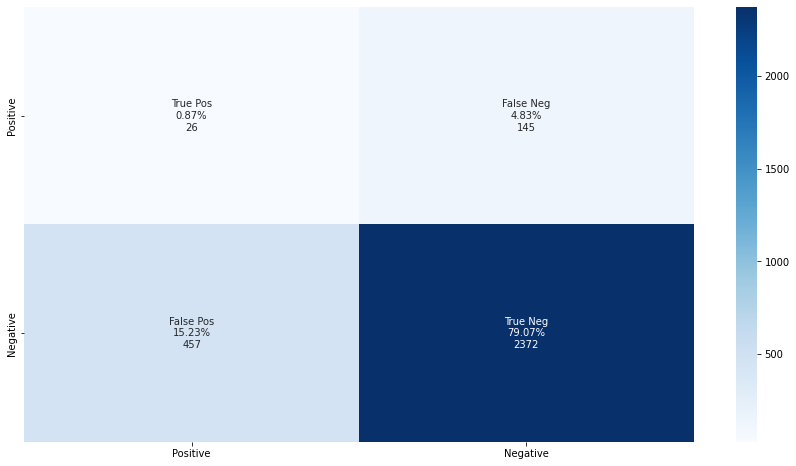

In [152]:
predict, original = [], []
for x, y in valloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        optimizer.zero_grad()
        y_hat = embeddingmodel(x)
        predict.extend(torch.argmax(y_hat, dim=1).cpu())
        original.extend(torch.argmax(y, dim=1).cpu())

show_result2group(['Negative' if int(x) == 1 else 'Positive' for x in predict], ['Negative' if int(x) == 1 else 'Positive' for x in original])

In [153]:
transform_x_unibi = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.todense()),
    torchvision.transforms.Lambda(lambda x: torch.from_numpy(x).type(torch.float)),
])
transform_y_unibi = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: torch.tensor(x)),
    torchvision.transforms.Lambda(lambda x: torch.nn.functional.one_hot(x, num_classes=2).type(torch.float)),
])

In [154]:
%%time
# run model

# constant
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCHS = 50
MOMENTUM = 0.9
DROPOUT = 0.9

# model
unibimodel = NeuralNetworkUnibi(DROPOUT).to(device)

# dataset
trainset = CustomTextDataset(unibitrainX, unibitrainY, transform_x_unibi, transform_y_unibi)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valset = CustomTextDataset(unibitestX, unibitestY, transform_x_unibi, transform_y_unibi)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

# loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


accuracy_list = []
loss_list = []
for epoch in range(EPOCHS):
    epoch_list = []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_hat = unibimodel(x)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()

        epoch_list.append(loss.item())
    
    val_size = 0
    accurate = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            optimizer.zero_grad()
            y_hat = unibimodel(x)
            accurate += (torch.argmax(y_hat, dim=1)==torch.argmax(y, dim=1)).sum()
        val_size += len(y)

    print("Epoch: {}, Accuracy: {}, Loss: {:.16f}".format(epoch+1, round(float(accurate/val_size), 2), np.mean(epoch_list)))

Epoch: 1, Accuracy: 0.6, Loss: 0.6947544368883689
Epoch: 2, Accuracy: 0.59, Loss: 0.6946373842893390
Epoch: 3, Accuracy: 0.61, Loss: 0.6947049761538283
Epoch: 4, Accuracy: 0.61, Loss: 0.6946481600545852
Epoch: 5, Accuracy: 0.6, Loss: 0.6948528633910721
Epoch: 6, Accuracy: 0.6, Loss: 0.6947877997122074
Epoch: 7, Accuracy: 0.62, Loss: 0.6946145253319104
Epoch: 8, Accuracy: 0.6, Loss: 0.6948800494941740
Epoch: 9, Accuracy: 0.61, Loss: 0.6948963067952102
Epoch: 10, Accuracy: 0.6, Loss: 0.6946597245553414
Epoch: 11, Accuracy: 0.6, Loss: 0.6946939872262083
Epoch: 12, Accuracy: 0.61, Loss: 0.6946553666049898
Epoch: 13, Accuracy: 0.6, Loss: 0.6947935145600872
Epoch: 14, Accuracy: 0.6, Loss: 0.6948832880263611
Epoch: 15, Accuracy: 0.6, Loss: 0.6948087458830263
Epoch: 16, Accuracy: 0.61, Loss: 0.6947750598428992
Epoch: 17, Accuracy: 0.6, Loss: 0.6947803960055492
Epoch: 18, Accuracy: 0.6, Loss: 0.6946306107407909
Epoch: 19, Accuracy: 0.6, Loss: 0.6947654712771586
Epoch: 20, Accuracy: 0.6, Loss: 0

              precision    recall  f1-score   support

    Positive       0.37      0.16      0.22      1129
    Negative       0.62      0.84      0.71      1871

    accuracy                           0.58      3000
   macro avg       0.50      0.50      0.47      3000
weighted avg       0.53      0.58      0.53      3000



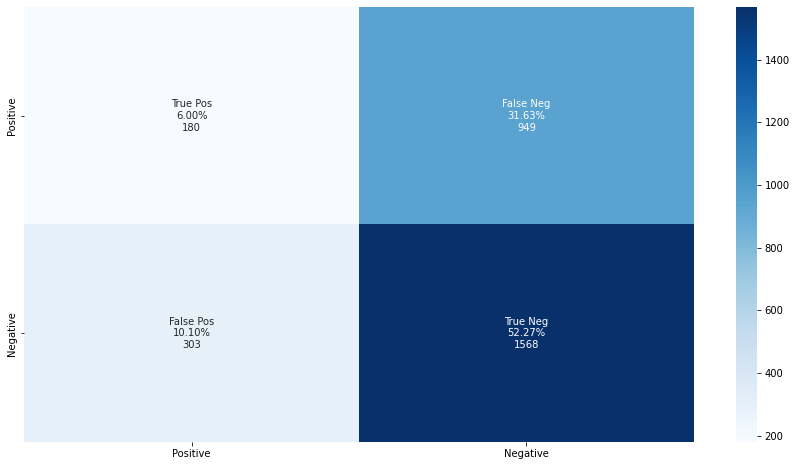

In [155]:
predict, original = [], []
for x, y in valloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        optimizer.zero_grad()
        y_hat = unibimodel(x)
        predict.extend(torch.argmax(y_hat, dim=1).cpu())
        original.extend(torch.argmax(y, dim=1).cpu())

show_result2group(['Negative' if int(x) == 1 else 'Positive' for x in predict], ['Negative' if int(x) == 1 else 'Positive' for x in original])